<a href="https://colab.research.google.com/github/xesmaze/cpsc541-fall2024/blob/main/lectures/CurveFittingAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this exercise we will be using the Abolone dataset.
You can download it from the UCI repository:https://archive.ics.uci.edu/dataset/1/abalone


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
from scipy.optimize import minimize, curve_fit, dual_annealing, least_squares
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the abalone dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/aba lone.data'
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
df = pd.read_csv(url, header=None, names=column_names)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Sex has the ```dtype``` object, but we need it as numerical. Lets one-hot-encode it to keep it in the data.

In [ ]:
# Convert categorical 'Sex' column to numerical
df = pd.get_dummies(df, columns=['Sex'], drop_first=False)

#df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Length         4177 non-null   float64
 1   Diameter       4177 non-null   float64
 2   Height         4177 non-null   float64
 3   WholeWeight    4177 non-null   float64
 4   ShuckedWeight  4177 non-null   float64
 5   VisceraWeight  4177 non-null   float64
 6   ShellWeight    4177 non-null   float64
 7   Rings          4177 non-null   int64  
 8   Sex_F          4177 non-null   bool   
 9   Sex_I          4177 non-null   bool   
 10  Sex_M          4177 non-null   bool   
dtypes: bool(3), float64(7), int64(1)
memory usage: 273.4 KB


<Figure size 1000x800 with 0 Axes>

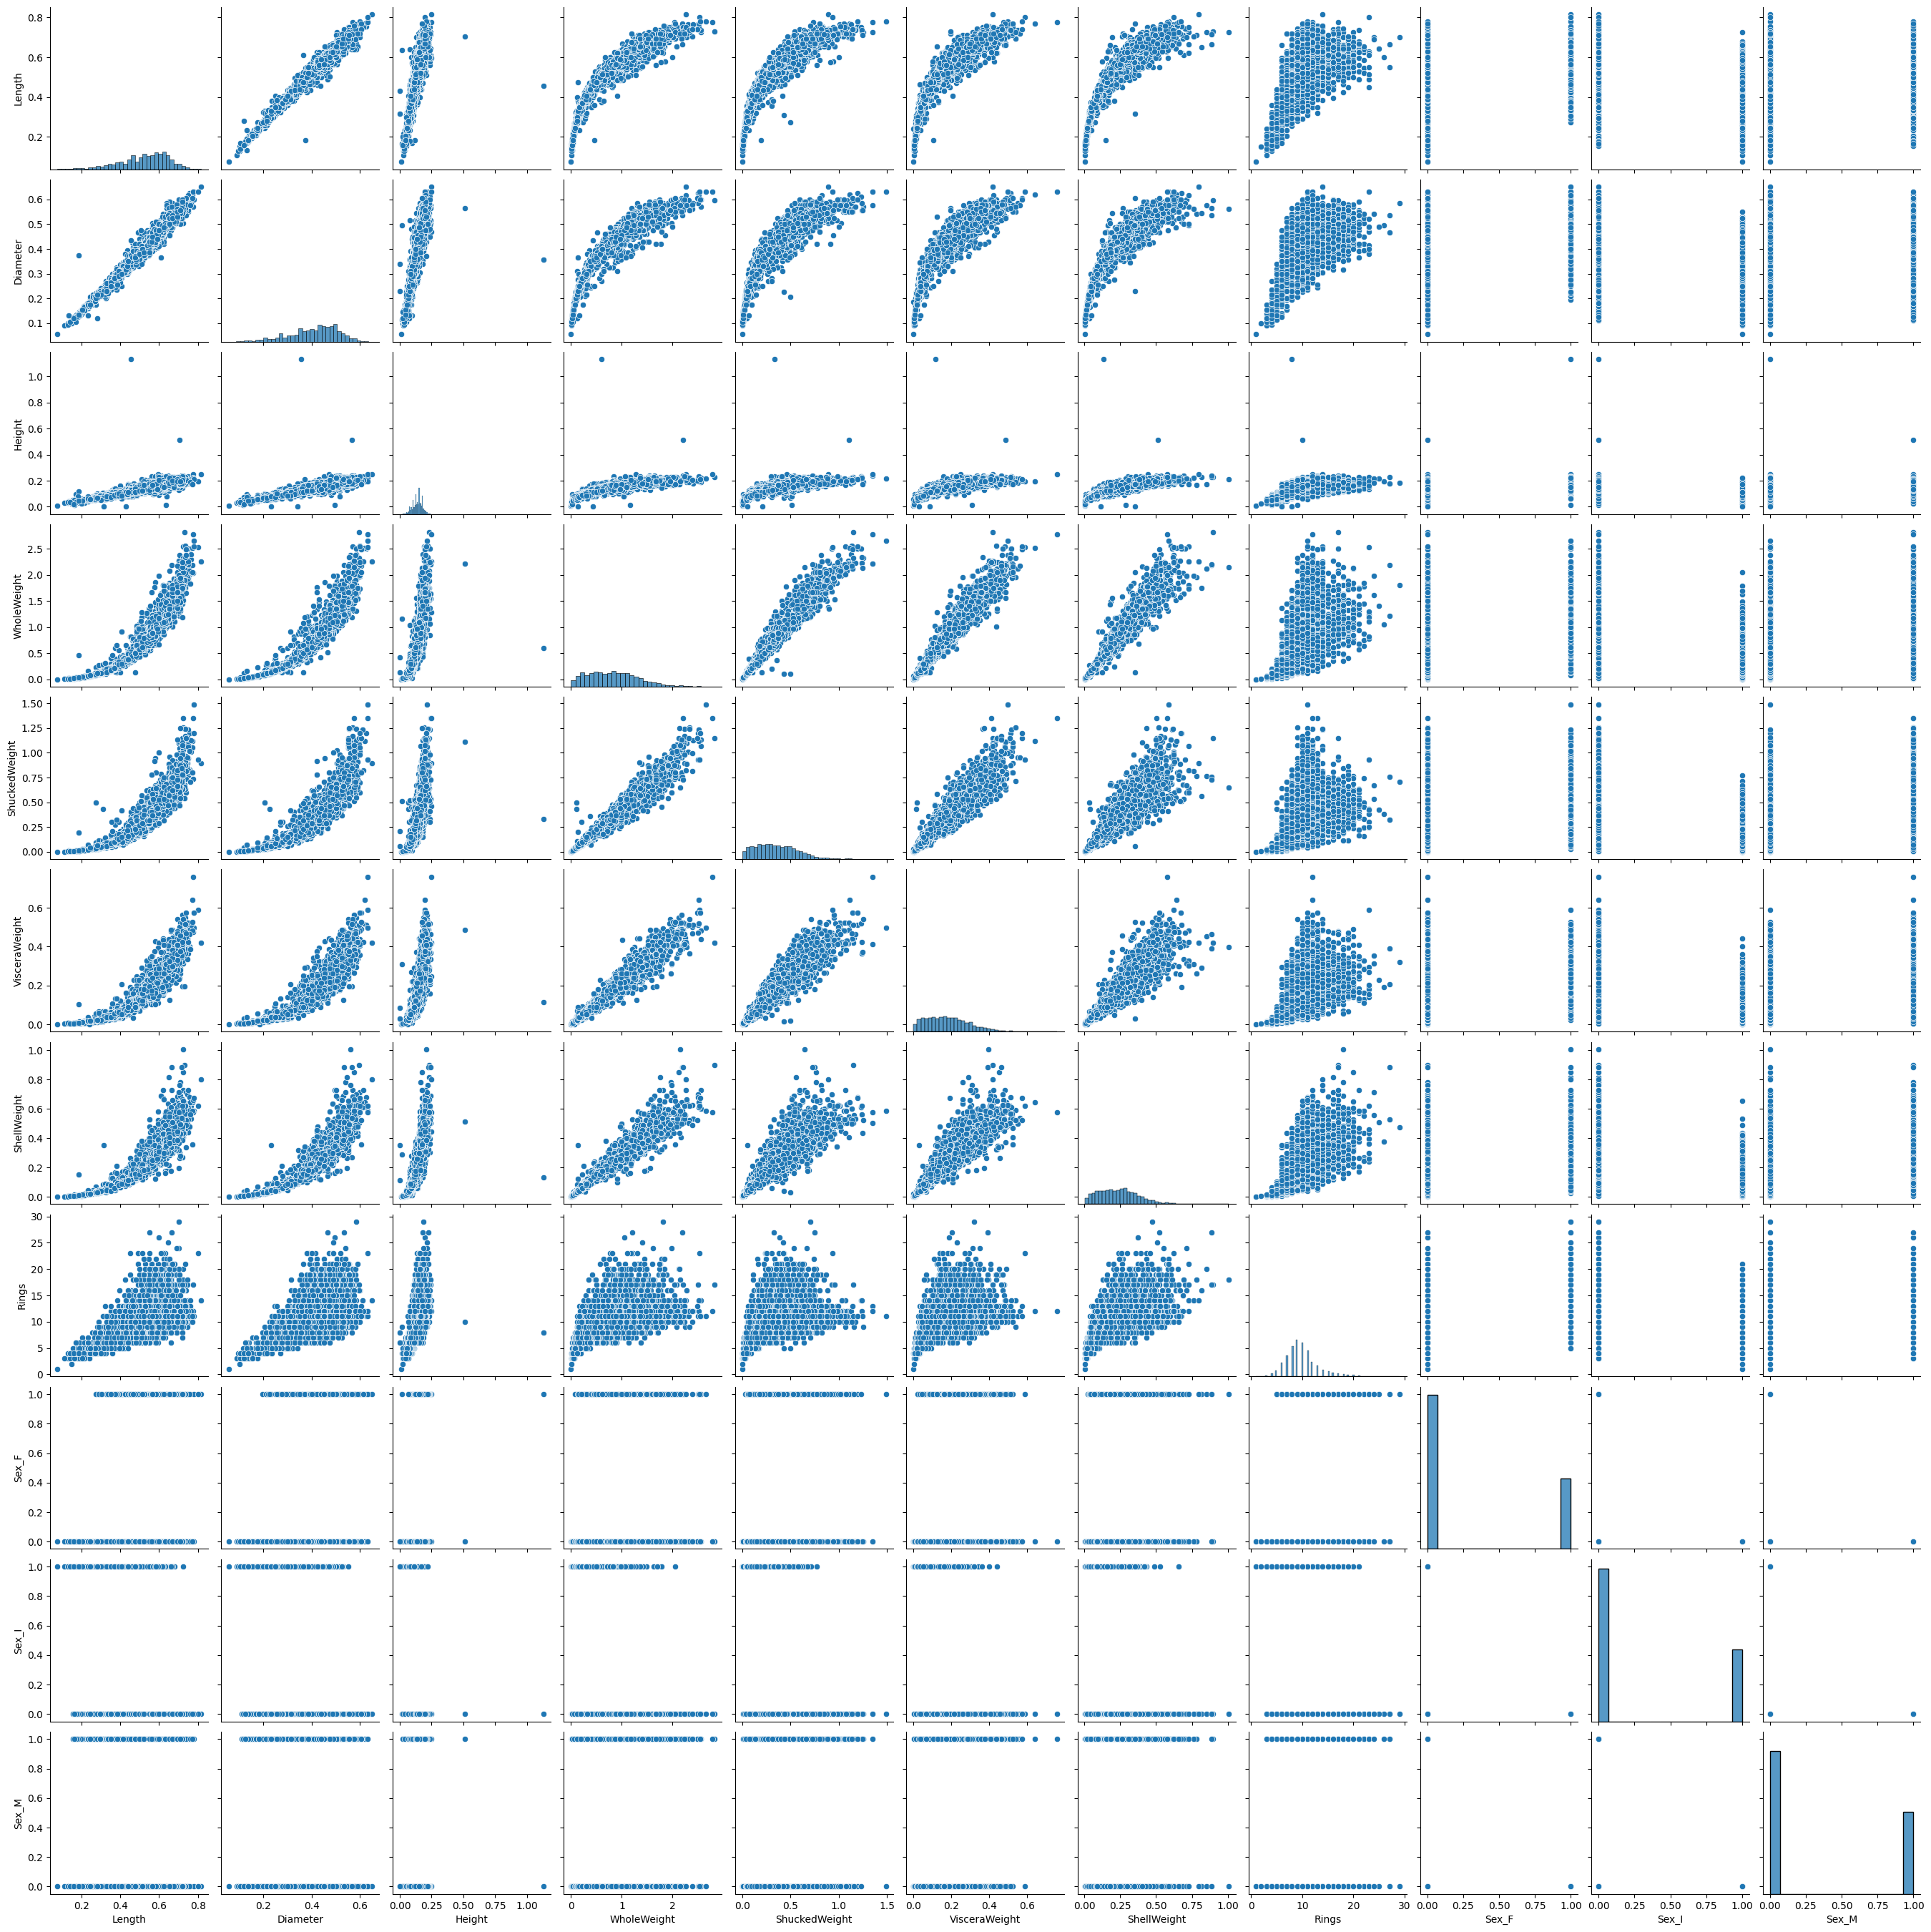

In [ ]:
# Create a pairs plot to visualize correlations between predictors
# with seaborn
plt.figure(figsize=(10, 8))
sns.pairplot(df)
plt.show()

In [ ]:
# with plotly
# Create a scatter matrix plot using Plotly Express
fig = px.scatter_matrix(
    df,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset- All data",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig.show()

This figure has no representation for the categorical variable sex- lets include facet for it, but the ```scatter.matrix()``` function does not support this.. So, to achieve the faceting effect, we'll need to create separate scatter matrix plots for each category of Sex.

 Unfortunately, Plotly subplots does not support combining this type of plots as subplots so if we would like to have a combined figure we will have to think of another way to that...


In [ ]:
# Subset data by sex
df_F = df[df['Sex_F'] == 1]
df_I = df[df['Sex_I'] == 1]
df_M = df[df['Sex_M'] == 1]

fig_F = px.scatter_matrix(
    df_F,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset - Females Only",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig_F.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig_F.show()

In [ ]:
fig_M = px.scatter_matrix(
    df_M,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset - Males Only",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig_M.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig_M.show()

In [ ]:
fig_I = px.scatter_matrix(
    df_I,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset - Juveniles Only",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig_I.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig_I.show()

There appears to be some outliers in each subset for the ```"Height"``` - lets drop some of those by identifying ranges to keep and drop data for this predictor. We should keep all the values under 0.5- and look at it again.

We should also track the samples we are dropping

In [ ]:
# Find the indices of rows where 'Height' is greater than 0.5
indices_to_drop = df[df['Height'] > 0.5].index

# Drop these rows from the DataFrame
df_filtered = df.drop(indices_to_drop)

# Print the rows of the data to be dropped
rows_to_drop = df.loc[indices_to_drop]

# Print the data of the rows that will be dropped
print(rows_to_drop)

      Length  Diameter  Height  WholeWeight  ShuckedWeight  VisceraWeight  \
1417   0.705     0.565   0.515        2.210         1.1075         0.4865   
2051   0.455     0.355   1.130        0.594         0.3320         0.1160   

      ShellWeight  Rings  Sex_F  Sex_I  Sex_M  
1417       0.5120     10  False  False   True  
2051       0.1335      8   True  False  False  


That doesn't look too bad, we can drop 2 entries without impact on overall performance....

In [ ]:
# Drop these rows from the DataFrame in place
df.drop(indices_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4175 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Length         4175 non-null   float64
 1   Diameter       4175 non-null   float64
 2   Height         4175 non-null   float64
 3   WholeWeight    4175 non-null   float64
 4   ShuckedWeight  4175 non-null   float64
 5   VisceraWeight  4175 non-null   float64
 6   ShellWeight    4175 non-null   float64
 7   Rings          4175 non-null   int64  
 8   Sex_F          4175 non-null   bool   
 9   Sex_I          4175 non-null   bool   
 10  Sex_M          4175 non-null   bool   
dtypes: bool(3), float64(7), int64(1)
memory usage: 305.8 KB


Let replot the figures...

In [ ]:
# Subset data by sex
df_F = df[df['Sex_F'] == 1]
df_I = df[df['Sex_I'] == 1]
df_M = df[df['Sex_M'] == 1]

fig_F = px.scatter_matrix(
    df_F,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset - Females Only",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig_F.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig_F.show()

In [ ]:
fig_M = px.scatter_matrix(
    df_M,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset - Males Only",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig_M.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig_M.show()

In [ ]:
fig_I = px.scatter_matrix(
    df_I,
    dimensions=['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'],
    color='Rings',
    title="Scatter Matrix of Abalone Dataset - Juveniles Only",
    labels={col: col.replace('_', ' ') for col in df.columns}
)

# Update layout for better visuals
fig_I.update_layout(
    width=900,
    height=900,
    hovermode='closest'
)

# Show the interactive plot
fig_I.show()

Looking much better...
Lets also look at the ```Height``` in facets for their distrubtion across the categories under ```Sex```

In [ ]:
import plotly.subplots as sp
import plotly.graph_objects as go

# List of features for pairwise plots
features = ['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight']

# Create subplots (we'll show Length vs Diameter, and Length vs Height for simplicity)
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=["Females", "Infants", "Males"],
                       shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.1)

# Add scatter plots for Length vs Diameter
#fig.add_trace(go.Scatter(x=df_F['Length'], y=df_F['Diameter'], mode='markers', name='Females', marker=dict(color='blue')), row=1, col=1)
#fig.add_trace(go.Scatter(x=df_I['Length'], y=df_I['Diameter'], mode='markers', name='Infants', marker=dict(color='orange')), row=1, col=2)
#fig.add_trace(go.Scatter(x=df_M['Length'], y=df_M['Diameter'], mode='markers', name='Males', marker=dict(color='green')), row=1, col=3)

# Add scatter plots for Length vs Height
fig.add_trace(go.Scatter(x=df_F['Length'], y=df_F['Height'], mode='markers', name='Females', marker=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_I['Length'], y=df_I['Height'], mode='markers', name='Infants', marker=dict(color='orange')), row=1, col=2)
fig.add_trace(go.Scatter(x=df_M['Length'], y=df_M['Height'], mode='markers', name='Males', marker=dict(color='green')), row=1, col=3)

# Update layout for aesthetics
fig.update_layout(
    height=500, width=1200,
    title_text="Scatter Plots Faceted by Sex: Length vs Diameter and Length vs Height",
#    xaxis_title="Length", yaxis_title="Diameter",
    xaxis_title="Length", yaxis_title="Height",
    showlegend=False
)

# Show the plot
fig.show()

Moving on...

Next, we will split the response variable from the data frame.
We will pick ```Rings``` as our response

In [ ]:
# Define the feature matrix X and the target variable y (predicting 'Rings' as age)
X = df.drop(columns='Rings').values
y = df['Rings'].values
X.shape

(4175, 10)

Next step is to split both x and y into train,test  and **validate** datasets. The validation fold, also called the **held-out set**  will serve to validate the models that we fit, as some of the techniques we will use have known tendencies for overfitting. We will discuss the details of how to decide the fractions for each later when we are discussing **cross-validation**

The procedure is

1.   Split the data into training + validation and test sets (80% for training + validation, 20% for test).

2.   Further split the training + validation set into training (80% of the non held-out) and validation (20% of the non-held-out).


In [ ]:
# Split the data into training+validation and testing sets (80% training+validation, 20% testing)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split the training+validation set into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

Lets check to make sure they are all reasonably sized datasets after the splits

In [ ]:
# Store the splits in a dictionary
splits = {
    'X_trainval': X_trainval,
    'X_test': X_test,
    'y_trainval': y_trainval,
    'y_test': y_test,
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val
}

# Loop over the splits and call info() on DataFrames only
for split_name, split_data in splits.items():
    print(f"\nInformation for {split_name}:")

    # Check if the data is a DataFrame before calling info()
    if isinstance(split_data, pd.DataFrame):
        split_data.info()  # Call .info() on DataFrames
    else:
        print(f"Shape of {split_name}: {split_data.shape}")  # For NumPy arrays



Information for X_trainval:
Shape of X_trainval: (3340, 10)

Information for X_test:
Shape of X_test: (835, 10)

Information for y_trainval:
Shape of y_trainval: (3340,)

Information for y_test:
Shape of y_test: (835,)

Information for X_train:
Shape of X_train: (2672, 10)

Information for X_val:
Shape of X_val: (668, 10)

Information for y_train:
Shape of y_train: (2672,)

Information for y_val:
Shape of y_val: (668,)


1. **Maximum Likelihood Estimation (MLE)**

The goal is to perform Maximum Likelihood Estimation (MLE) for fitting a linear regression model by **minimizing the negative log-likelihood (NLL) function**. The parameters to estimate include the regression coefficients (```beta```) and the standard deviation of the error term (```sigma```).

For instance, for Normal distribution, the likelihood is calculated as follows:
$$
\ell(\theta| X) = \ln[L(\theta|X)]
$$

$$
= \ln \left( \left( 2 \pi \sigma^2 \right)^{-\frac{n}{2}} \exp \left( - \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2 \right) \right)
$$

$$
= \ln \left( \left( 2 \pi \sigma^2 \right)^{-\frac{n}{2}} \right) + \ln \left( \exp \left( - \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2 \right) \right)
$$

$$
= - \frac{n}{2} \ln(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2
$$

$$
= - \frac{n}{2} \ln(2 \pi) - \frac{n}{2} \ln(\sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2
$$

To derive the negative log-likelihood we simply the negative of the log-likelihood function. Hence, we can express it as:

$$
- \ell(\theta| X) = -(- \frac{n}{2} \ln(2 \pi) - \frac{n}{2} \ln(\sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2)
$$

$$
= \frac{n}{2} \ln(2 \pi) + \frac{n}{2} \ln(\sigma^2) + \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2
$$

where  $ln \sigma^2$  simplifies to $ 2 ln(\sigma)$ and therefore

$$
\frac{n}{2} \ln(\sigma^2) = n\ln(\sigma)
$$

and the negative log-likelihood becomes:
$$
= \frac{n}{2} \ln(2 \pi) +  n\ln(\sigma) + \frac{1}{2 \sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2
$$


In [ ]:
### 1. Maximum Likelihood Estimation (MLE)
# Define the likelihood function as a reference - we will not use this, it is computationally expensive
def likelihood(params, X, y):
    beta = params[:-1]  # Coefficients for the predictors (linear model)
    sigma = params[-1]  # Standard deviation (error term)

    # Number of observations
    n = len(y)

    # Predicted values based on the linear model
    y_pred = X @ beta

    # Residuals (actual - predicted values)
    residuals = y - y_pred

    # Likelihood calculation (product of individual Gaussian likelihoods)
    likelihood = (1 / np.sqrt(2 * np.pi * sigma**2)) ** n * np.exp(-np.sum(residuals ** 2) / (2 * sigma ** 2))

    return likelihood

# Define the negative log-likelihood (NLL) based on the new formula, which will be what we will use
def neg_log_likelihood(params, X, y):
    beta = params[:-1]  # coefficients for the predictors (linear model)
    sigma = params[-1]  # standard deviation (error term)

    # Number of observations
    n = len(y)

    # Predicted values based on the linear model
    y_pred = X @ beta

    # Residuals (actual - predicted values)
    residuals = y - y_pred

    # NLL computation based on the formula:
    # NLL = (n/2) * ln(2π) + n * ln(σ) + (1 / (2 * σ^2)) * sum(residuals^2)
    nll = (n / 2) * np.log(2 * np.pi) + n * np.log(sigma) + (1 / (2 * sigma ** 2)) * np.sum(residuals ** 2)

    return nll_norm

We will need more general purpose functions, that can work for all sorts of distributions, so we will slightly modify the functions as follows:

In [ ]:
### 1. Maximum Likelihood Estimation (MLE)
# Define general purpose negative log-likelihood function
def neg_log_likelihood(params, X, y):
    beta = params[:-1]  # coefficients
    sigma = params[-1]  # error term (standard deviation)
    y_pred = X @ beta
    residuals = y - y_pred
    nll = 0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return nll

# Initial guesses for MLE
initial_params = np.append(np.ones(X_train.shape[1]), 1)

# Fit the model using MLE on the training set
result_mle = minimize(neg_log_likelihood, initial_params, args=(X_train, y_train))
mle_params = result_mle.x

beta_mle = mle_params[:-1]  # Regression coefficients
sigma_mle = mle_params[-1]   # Estimated standard deviation of residuals (sigma)

# Predict the response on the validation set using the MLE-fitted model
y_pred_val_mle = X_val @ beta_mle

# Validate the model on the validation set using MLE
y_pred_val_mle = X_val @ mle_params[:-1]

# Optionally, calculate the mean squared error (MSE) on the validation set
mse_val_mle = np.mean((y_val - y_pred_val_mle) ** 2)
print("Validation MSE (MLE):", mse_val_mle)

# Print the estimated coefficients and sigma
print("Estimated coefficients (beta):", beta_mle)
print("Estimated sigma (standard deviation):", sigma_mle)

Validation MSE (MLE): 4.616314869048229
Estimated coefficients (beta): [ -3.1197822   11.1369103   24.86248218   8.30670838 -18.61963318
  -9.06473231   7.26652722   3.50656329   2.81477854   3.48642953]
Estimated sigma (standard deviation): 2.199579081333139


**Code Breakdown:**

  1. **Negative Log-Likelihood (NLL) Function:** The ```neg_log_likelihood()``` function computes the negative log-likelihood of the data given the model parameters (beta and sigma).
  2. **X @ beta:** This computes the predicted values based on the linear model. The residuals (residuals = y - y_pred) represent the difference between the actual and predicted values.

The NLL combines the squared residuals divided by sigma, along with a term for the Gaussian likelihood (the log of sigma).

  3. **Initial Parameter Guesses:** We initialize the regression coefficients (```beta```) as ones and the error term (```sigma```) as 1. These are stored in ```initial_params```.
  4. **Optimization Using minimize()**: The ```minimize()``` function from ```scipy.optimize``` is used to find the parameters that minimize the NLL.
  5. The result of this optimization is stored in ```result_mle```, and the estimated parameters ```(mle_params)``` are extracted from it.
  6. **Prediction on Validation Set:**The predicted values for the validation set are computed using the estimated regression coefficients (```beta```) and ```X_val```.

We can further improve the fit by using more sophisticated optimization methods such as ```L=BFGS-B```
```
# Fit the model using Maximum Likelihood Estimation (MLE)
result_mle = minimize(neg_log_likelihood, initial_params, args=(X_train, y_train),
                      method='L-BFGS-B',
                      bounds=[(None, None)] * X_train.shape[1] + [(1e-6, None)])  # Constrain sigma to be positive

# Extract the estimated parameters from the optimization result
mle_params = result_mle.x
beta_mle = mle_params[:-1]  # Regression coefficients
sigma_mle = mle_params[-1]   # Estimated standard deviation of residuals (sigma)

# Predict the response on the validation set using the MLE-fitted model
y_pred_val_mle = X_val @ beta_mle

# Print the estimated coefficients and sigma
print("Estimated coefficients (beta):", beta_mle)
print("Estimated sigma (standard deviation):", sigma_mle)

# Optionally, calculate the mean squared error (MSE) on the validation set
mse_val_mle = np.mean((y_val - y_pred_val_mle) ** 2)
print("Validation MSE (MLE):", mse_val_mle)
```

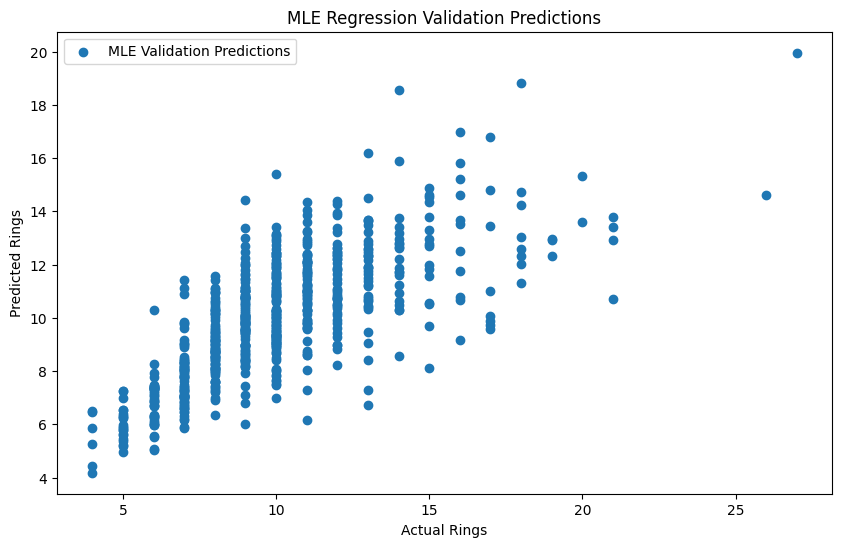

In [ ]:
# Visualize MLE validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_mle, label='MLE Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('MLE Regression Validation Predictions')
plt.legend()
plt.show()

**2. Restricted Maximum Likelihood (REML)**

Restricted Maximum Likelihood (REML), a technique typically used in mixed-effects models to estimate the variance components (such as random effects) in hierarchical data. In the context of REML, the goal is **to maximize the likelihood of the residuals, factoring out the fixed effects**.

REML differs from Maximum Likelihood Estimation (MLE) in that it focuses on maximizing the likelihood of the residuals, not the full model, **which avoids bias when estimating variance components in models with random effects.** While REML is commonly used in mixed models, here we will focus on a general framework that illustrates the concept.

**Key Differences Between REML and MLE:**

MLE estimates both fixed effects (coefficients) and variance components simultaneously, which can lead to biased estimates of the variance components.

REML adjusts for the fixed effects and estimates the variance components more accurately, especially in models with random effects.

In this example, we assume that the structure includes fixed effects (coefficients for the predictors) and random effects (variance components). The REML method aims to provide better variance estimates by removing the influence of fixed effects.

**Generalized REML Code Example for a Linear Model:**

Below, we'll write a simplified REML approach, assuming random effects for the variance estimation. Since REML is most useful when random effects are present (such as in mixed models), we adapt the code to show how you might calculate the restricted likelihood.



In [ ]:
### 2. Restricted Maximum Likelihood (REML)
# REML is mainly used in mixed-effect models; here we demonstrate a simplified version with random effects

# Define the likelihood for a mixed-effects model (simplified)
def reml_likelihood(params, X, y):
    beta = params[:-2]  # fixed effects
    sigma_e = params[-2]  # residual error
    sigma_u = params[-1]  # random effect variance
    y_pred = X @ beta
    nll = 0.5 * np.sum((y - y_pred)**2 / sigma_e**2 + np.log(sigma_e**2))
    reml_penalty = np.log(sigma_u**2)
    return nll + reml_penalty


In [ ]:
# Fit the REML model
initial_reml = np.append(np.ones(X_train.shape[1]), [1, 1])
result_reml = minimize(reml_likelihood, initial_reml, args=(X_train, y_train))
reml_params = result_reml.x # Parameters from REML optimization

# Predict on test set using REML
y_pred_reml = X_test @ reml_params[:-2]

# Extract the estimated parameters
beta_reml = reml_params[:-1]  # Estimated fixed effects (beta)
sigma_reml = reml_params[-1]  # Estimated standard deviation (sigma)


y_pred_test_reml = X_test @ reml_params[:-2]

# Test the model predictions for the test set
# print("Predictions on test set (REML):", y_pred_test_reml)

# Calculate the mean squared error (MSE) on the test set
mse_test_reml = np.mean((y_test - y_pred_test_reml) ** 2)
print("Test MSE (REML):", mse_test_reml)

# Optionally, you could calculate other metrics such as R-squared or residuals:
# R-squared on the test set
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
ss_res = np.sum((y_test - y_pred_test_reml) ** 2)
r_squared_test = 1 - (ss_res / ss_total)
print("Test R-squared (REML):", r_squared_test)

# Predict the response on the validation set using the REML-fitted model
y_pred_val_reml = X_val @ reml_params[:-2]

# Print the estimated coefficients and sigma
print("Estimated coefficients (beta, REML):", beta_reml)
print("Estimated sigma (standard deviation, REML):", sigma_reml)

# Optionally, calculate the mean squared error (MSE) on the validation set
mse_val_reml = np.mean((y_val - y_pred_val_reml) ** 2)
print("Validation MSE (REML):", mse_val_reml)

Test MSE (REML): 4.592252075941986
Test R-squared (REML): 0.5688775050508525
Estimated coefficients (beta, REML): [ -3.3506322   11.61837884  25.94087033   8.54245616 -18.94349768
  -9.53566904   6.92271744   3.36590071   2.68698623   3.35490457
   2.18226156]
Estimated sigma (standard deviation, REML): -30.1985919012115
Validation MSE (REML): 4.6154046420021935


In [ ]:
# Visualize in Validation and Test Sets

import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a two-faceted plotly figure
fig = make_subplots(rows=1, cols=2,shared_yaxes=True , subplot_titles=("Validation Set", "Test Set"))

# REML predictions on the validation set
fig.add_trace(
    go.Scatter(x=y_val, y=y_pred_val_reml, mode='markers', name='Validation Set',
               marker=dict(color='blue'), showlegend=False),
    row=1, col=1
)

# REML predictions on the test set
fig.add_trace(
    go.Scatter(x=y_test, y=y_pred_test_reml, mode='markers', name='Test Set',
               marker=dict(color='green'), showlegend=False),
    row=1, col=2
)

# Update xaxis and yaxis titles for both subplots
fig.update_xaxes(title_text="Actual Rings", row=1, col=1)
fig.update_yaxes(title_text="Predicted Rings", row=1, col=1)

fig.update_xaxes(title_text="Actual Rings", row=1, col=2)
fig.update_yaxes(title_text="Predicted Rings", row=1, col=2)

# Update layout with a title
fig.update_layout(title_text="REML Regression Predictions - Validation vs Test Set", height=600, width=1000)

# Show the interactive plot
fig.show()


In [ ]:
# Here is a more sophisticated for REML implementation- that will adjust for the fixed effects
# Define the REML negative log-likelihood function, adjusted for the one-hot encoded Sex variable
import numpy as np
from scipy.optimize import minimize
# read the manual for the methods
# https://docs.scipy.org/doc/scipy/reference/optimize.html


# Define the REML negative log-likelihood function, adjusted for the one-hot encoded Sex variable
def reml_neg_log_likelihood(params, X, y):
    beta = params[:-1]  # Fixed effects (regression coefficients)
    sigma = params[-1]  # Standard deviation of residuals (error term)

    # Ensure sigma is positive and large enough to avoid numerical issues
    if sigma <= 0:
        return np.inf

    # Number of observations and predictors
    n, p = X.shape

    # Predicted values based on the linear model (fixed effects)
    y_pred = X @ beta

    # Residuals
    residuals = y - y_pred

    # Calculate RSS (residual sum of squares)
    rss = np.sum(residuals ** 2)

    # REML part: Adjust the log-likelihood for the fixed effects by considering the determinant of (X^T X)
    XtX = X.T @ X

    # Regularize XtX to avoid singular matrix (add small value to diagonal)
    reg = 1e-6 * np.eye(XtX.shape[0])  # Regularization term
    XtX_reg = XtX + reg

    try:
        # Calculate the log determinant of the regularized XtX matrix
        log_det_xtx = np.log(np.linalg.det(XtX_reg))
    except np.linalg.LinAlgError:
        print("Singular matrix detected in XtX")
        return np.inf  # Return infinity if XtX is singular

    # REML NLL calculation
    reml_nll = (n - p) * np.log(sigma) + 0.5 * rss / sigma**2 + 0.5 * log_det_xtx + 0.5 * (n - p) * np.log(2 * np.pi)

    # Debug: Print the current state of sigma, rss, and log_det_xtx
    # print(f"sigma: {sigma}, RSS: {rss}, log(det(XtX)): {log_det_xtx}")

    return reml_nll

In [ ]:
X_test.dtype

dtype('O')

**This means my data frames are objects and I have to convert them to float for the linear algebra to work!!**

In [ ]:
# Before fitting the model- we need to ensure all data is numeric, as there may be issues
# Ensure X_train is fully numeric
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

X_train.dtype

dtype('float64')

In [ ]:
# Initial guesses for the parameters (ones for beta and 1 for sigma)
initial_params = np.append(np.ones(X_train.shape[1]), 1)

# Fit the model using REML by minimizing the REML negative log-likelihood
result_reml_nll = minimize(reml_neg_log_likelihood, initial_params, args=(X_train, y_train),
                          method='L-BFGS-B', bounds=[(None, None)] * X_train.shape[1] + [(1e-6, None)])

# Check if the optimization was successful
if result_reml_nll.success:
    # Extract the estimated parameters
    reml_params = result_reml_nll.x  # Parameters from REML optimization
    beta_reml = reml_params[:-1]  # Estimated fixed effects (beta)
    sigma_reml = reml_params[-1]  # Estimated standard deviation (sigma)

    # Predict the response on the validation set using the REML-fitted model
    y_pred_val_reml = X_val @ beta_reml

    # Print the estimated coefficients and sigma
    print("Estimated coefficients (beta, REML):", beta_reml)
    print("Estimated sigma (standard deviation, REML):", sigma_reml)

    # Optionally, calculate the mean squared error (MSE) on the validation set
    mse_val_reml = np.mean((y_val - y_pred_val_reml) ** 2)
    print("Validation MSE (REML):", mse_val_reml)

    # Predict the response on the test set
    y_pred_test_reml = X_test @ beta_reml
    mse_test_reml = np.mean((y_test - y_pred_test_reml) ** 2)
    #print("Test MSE (REML):", mse_test_reml)
else:
    print("Optimization failed:", result_reml_nll.message)


Estimated coefficients (beta, REML): [ -3.14321486  11.15834858  24.88658403   8.31253489 -18.62016557
  -9.07883217   7.25700783   3.50695941   2.81539497   3.48667701]
Estimated sigma (standard deviation, REML): 2.203726873127173
Validation MSE (REML): 4.616364480755649


**Code breakdown:**

We define the function reml_neg_log_likelihood to calculate the negative log-likelihood for REML, ensuring that the variance parameter sigma is positive.

**Initial Guesses:** Initial parameter guesses are provided for the regression coefficients (beta) and the residual variance (sigma).

**Optimization:** The REML NLL is minimized using the minimize function, with L-BFGS-B as the optimization method to handle bounded constraints for sigma (positive variance).

**Predictions:** Once the REML model is fitted using X_train and y_train, predictions are made on the validation set (X_val) using the estimated beta_reml (coefficients).

**Model Evaluation:** The Mean Squared Error (MSE) is calculated on the validation set to evaluate the model's performance. You can also compute other metrics, such as R-squared or residual plots, to analyze the model further.

In [ ]:
# Predict the response on the test set using the REML-fitted model
y_pred_test_reml = X_test @ beta_reml

# Print the predictions for the test set
# print("Predictions on test set (REML):", y_pred_test_reml)

# Calculate the mean squared error (MSE) on the test set
mse_test_reml = np.mean((y_test - y_pred_test_reml) ** 2)
print("Test MSE (REML):", mse_test_reml)

# Optionally, you could calculate other metrics such as R-squared or residuals:
# R-squared on the test set
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
ss_res = np.sum((y_test - y_pred_test_reml) ** 2)
r_squared_test = 1 - (ss_res / ss_total)
print("Test R-squared (REML):", r_squared_test)

Test MSE (REML): 4.59481131043817
Test R-squared (REML): 0.5686372430741777


In [ ]:
# Now the validation data- that was held out
# Predict the response on the validation set using the REML-fitted model
y_pred_val_reml = X_val @ beta_reml

#Calculate the mean squared error (MSE) on the validation set
mse_val_reml = np.mean((y_val - y_pred_val_reml) ** 2)

# R-squared on the validation set
ss_total = np.sum((y_val - np.mean(y_val)) ** 2)
ss_res = np.sum((y_val - y_pred_val_reml) ** 2)
r_squared_val = 1 - (ss_res / ss_total)

# Print
print("Test MSE (REML):", mse_test_reml)
print("Test R-squared (REML):", r_squared_test)
#print("Estimated coefficients (beta, REML):", beta_reml)
#print("Estimated sigma (standard deviation, REML):", sigma_reml)
print("Validation MSE (REML):", mse_val_reml)
print("Validation R-squared (REML):", r_squared_val)

Test MSE (REML): 4.59481131043817
Test R-squared (REML): 0.5686372430741777
Validation MSE (REML): 4.616364480755649
Validation R-squared (REML): 0.5298670566476898


**3. Simulated Annealing**


In [ ]:
### 3. Simulated Annealing (SA)
# Define the objective function for Simulated Annealing (Residual Sum of Squares)
def objective_function(params, X, y):
    beta = params
    y_pred = X @ beta
    return np.sum((y - y_pred)**2)

## We will use a library function called dual annealing from scipy
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html

# Fit model using Simulated Annealing
bounds = [(-10, 10)] * X_train.shape[1]
result_sa = dual_annealing(objective_function, bounds, args=(X_train, y_train))
sa_params = result_sa.x

# Predict on test set using SA
y_pred_sa = X_test @ sa_params


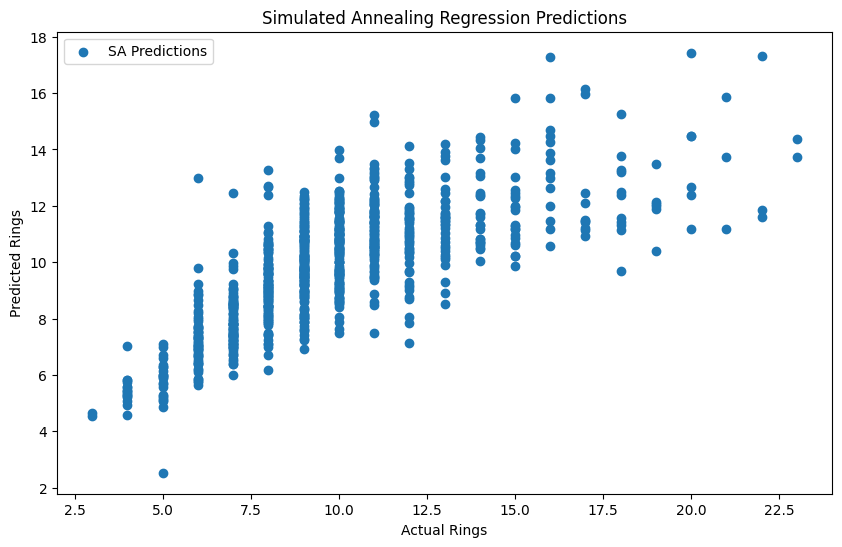

In [ ]:
# Visualize Simulated Annealing results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_sa, label='SA Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Simulated Annealing Regression Predictions')
plt.legend()
plt.show()

Lets try to implement a version of this on our own...

We will need to


1.   Define an objective function to minimize (for example, using the Mean Squared Error (MSE) between predicted and actual values).
2. Apply Simulated Annealing to optimize the regression coefficients (beta), including those corresponding to the one-hot encoded Sex variables.
3. Incorporate the bounds and temperature control into the optimization process.

 We'll use a simple linear regression model where we are optimizing the regression coefficients. The objective function will be the MSE between the actual Rings values and the predicted Rings values, based on the current coefficients.

**The goal is to find the optimal set of regression coefficients (beta) that minimizes the MSE.**

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assume X_trainval, X_val, X_test, y_trainval, y_val, y_test are already defined and one-hot encoded for 'Sex' variable
# Ensure all arrays are numpy arrays

# Scale the features for better optimization
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the objective function (Mean Squared Error)
def objective_function(beta, X, y):
    # Predicted values using linear regression
    y_pred = X @ beta
    # Calculate MSE between actual and predicted
    mse = mean_squared_error(y, y_pred)
    return mse

# Define the Simulated Annealing algorithm
def simulated_annealing(objective, X, y, n_iterations, initial_temp, cooling_rate, bounds):
    # Randomly initialize the coefficients (beta) within the bounds
    beta = np.random.uniform(bounds[0], bounds[1], X.shape[1])
    current_solution = beta
    current_cost = objective(current_solution, X, y)

    # Initialize the best solution
    best_solution = current_solution
    best_cost = current_cost

    # Initial temperature
    temperature = initial_temp

    # Annealing process
    for iteration in range(n_iterations):
        # Perturb the current solution slightly
        candidate_solution = current_solution + np.random.uniform(-0.1, 0.1, size=X.shape[1])

        # Ensure the candidate stays within bounds
        candidate_solution = np.clip(candidate_solution, bounds[0], bounds[1])

        # Evaluate the candidate solution
        candidate_cost = objective(candidate_solution, X, y)

        # Calculate the change in cost
        cost_diff = candidate_cost - current_cost

        # Accept the new solution based on the Metropolis criterion
        if cost_diff < 0 or np.exp(-cost_diff / temperature) > np.random.rand():
            current_solution = candidate_solution
            current_cost = candidate_cost

        # Update the best solution found so far
        if current_cost < best_cost:
            best_solution = current_solution
            best_cost = current_cost

        # Cool down the temperature
        temperature = temperature * cooling_rate

        # Optionally, print the progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Best MSE: {best_cost}, Temperature: {temperature}")

    return best_solution, best_cost

# Set bounds for the coefficients (this can be problem-dependent, using reasonable ranges)
bounds = [-10, 10]  # Adjust bounds based on feature scaling

# Set parameters for the Simulated Annealing algorithm
n_iterations = 1000
initial_temp = 10
cooling_rate = 0.99

# Run Simulated Annealing to minimize MSE for the Abalone dataset (using X_trainval for training)
best_solution, best_mse = simulated_annealing(objective_function, X_trainval_scaled, y_trainval, n_iterations, initial_temp, cooling_rate, bounds)

# Print the best solution found and the corresponding MSE
print(f"Best coefficients (beta): {best_solution}")
print(f"Best MSE on training set: {best_mse}")

# Evaluate the solution on the validation set
y_pred_val = X_val_scaled @ best_solution
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"MSE on validation set: {mse_val}")

# Evaluate the solution on the test set
y_pred_test = X_test_scaled @ best_solution
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"MSE on test set: {mse_test}")


Iteration 0, Best MSE: 864.536415504577, Temperature: 9.9
Iteration 100, Best MSE: 633.6013167731084, Temperature: 3.623720178604968
Iteration 200, Best MSE: 505.20153536442206, Temperature: 1.3263987810938207
Iteration 300, Best MSE: 340.73897683227455, Temperature: 0.4855048513057284
Iteration 400, Best MSE: 257.7566611495695, Temperature: 0.17771047742294666
Iteration 500, Best MSE: 192.93120688462446, Temperature: 0.06504778211990449
Iteration 600, Best MSE: 154.95561468289068, Temperature: 0.023809591983979528
Iteration 700, Best MSE: 128.2184124007671, Temperature: 0.008715080698656341
Iteration 800, Best MSE: 112.74338689883875, Temperature: 0.0031900013925143097
Iteration 900, Best MSE: 107.91421259645432, Temperature: 0.001167643678366874
Best coefficients (beta): [ 0.78315664  1.27176568  1.55554903 -7.5044798   2.2976568  -1.42204403
  5.07635197 -2.40526003 -2.56535461 -2.42092133]
Best MSE on training set: 106.28021996307716
MSE on validation set: 107.09184294538119
MSE on

We can further optimize by

**1. Adjusting Bounds:** You may want to adjust the bounds ([-10, 10]) for the coefficients based on the scale of the features after scaling.

**2. Hyperparameter Tuning:**
You can experiment with different values for n_iterations, initial_temp, and cooling_rate to improve performance.

In [ ]:
# Visualize
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error

# Predicted values on validation and test sets
y_pred_val = X_val_scaled @ best_solution
y_pred_test = X_test_scaled @ best_solution

# Create a two-faceted plotly figure
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Validation Set", "Test Set"))

# Validation set results (actual vs predicted)
fig.add_trace(
    go.Scatter(x=y_val, y=y_pred_val, mode='markers', name='Validation Set',
               marker=dict(color='blue'), showlegend=False),
    row=1, col=1
)

# Test set results (actual vs predicted)
fig.add_trace(
    go.Scatter(x=y_test, y=y_pred_test, mode='markers', name='Test Set',
               marker=dict(color='green'), showlegend=False),
    row=1, col=2
)

# Update x-axis titles for both subplots
fig.update_xaxes(title_text="Actual Rings", row=1, col=1)
fig.update_xaxes(title_text="Actual Rings", row=1, col=2)

# Update the shared y-axis title for both subplots
fig.update_yaxes(title_text="Predicted Rings", row=1, col=1)

# Add a layout title
fig.update_layout(title_text="Simulated Annealing Regression Predictions - Validation vs Test Set", height=600, width=1000)

# Show the plot
fig.show()


You can further enhance the visualization by adding a diagonal reference line (y = x), residual plots, or trend lines to help assess the quality of the fit.

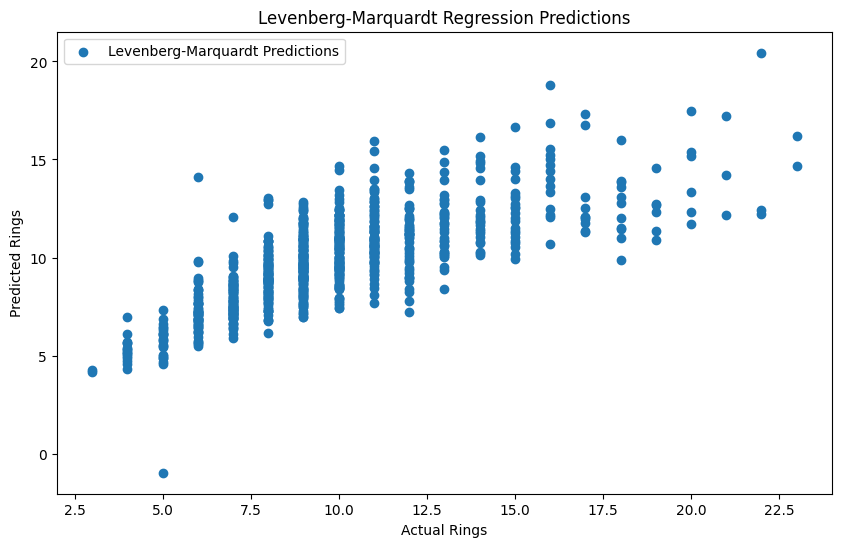

In [ ]:
### 4. Levenberg-Marquardt Algorithm

#First simple implementation using a library function

# Define the residuals function
def residuals_lm(params, X, y):
    return X @ params - y

# Initial parameter guess for Levenberg-Marquardt
initial_lm = np.ones(X_train.shape[1])

# Fit model using Levenberg-Marquardt
result_lm = least_squares(residuals_lm, initial_lm, args=(X_train, y_train), method='lm')
lm_params = result_lm.x

# Predict on test set using LM
y_pred_lm = X_test @ lm_params

# Visualize Levenberg-Marquardt results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lm, label='Levenberg-Marquardt Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Levenberg-Marquardt Regression Predictions')
plt.legend()
plt.show()



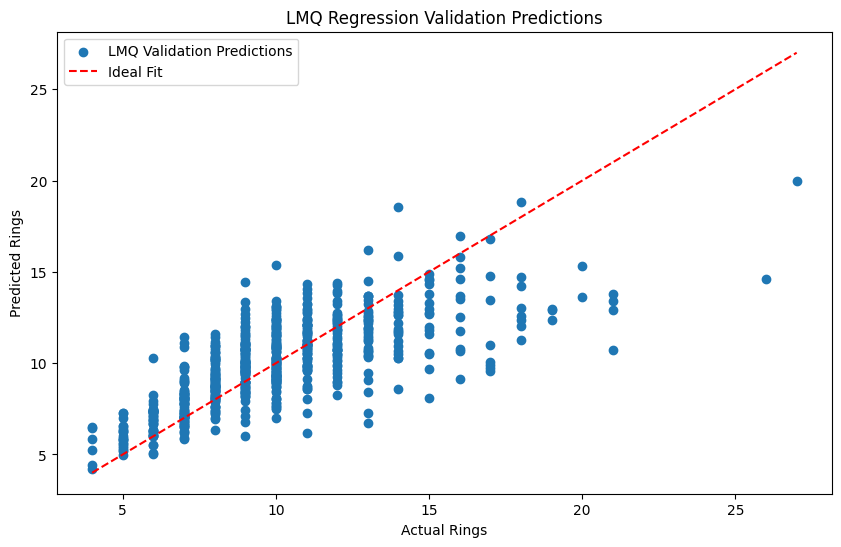

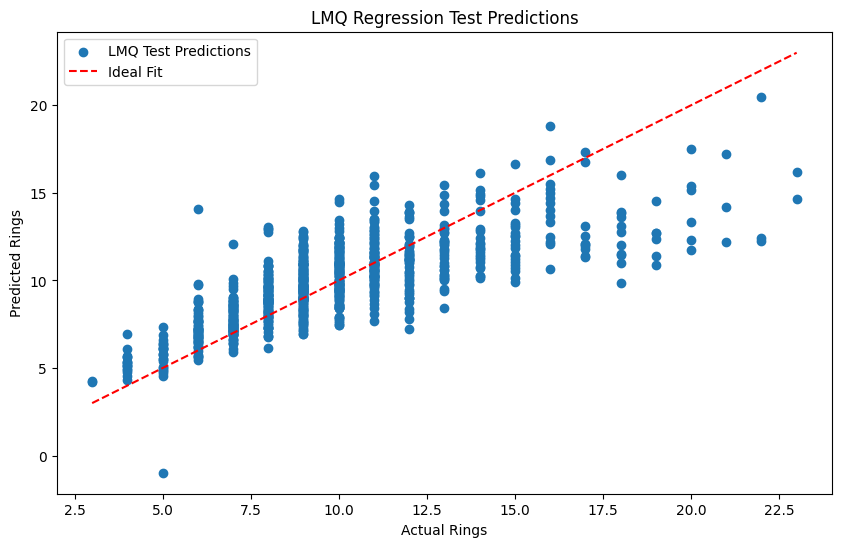

LMQ Test Set Performance: MSE = 4.595, R-squared = 0.569


In [ ]:
## Now lets implement our version

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Define the residuals function for LMQ
def residuals_lmq(params, X, y):
    return X @ params - y

# Initial parameter guess for LMQ
initial_lmq = np.ones(X_train.shape[1])

# Fit model using LMQ on the training set
result_lmq = least_squares(residuals_lmq, initial_lmq, args=(X_train, y_train), method='lm')
lmq_params = result_lmq.x

# Predict on validation set using LMQ
y_pred_val_lmq = X_val @ lmq_params

# Visualize LMQ results on validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_lmq, label='LMQ Validation Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('LMQ Regression Validation Predictions')
plt.legend()
plt.show()

# Predict on test set using LMQ
y_pred_test_lmq = X_test @ lmq_params

# Visualize LMQ results on test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_lmq, label='LMQ Test Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('LMQ Regression Test Predictions')
plt.legend()
plt.show()

# Evaluate the model on the test set
from sklearn.metrics import mean_squared_error, r2_score

mse_test_lmq = mean_squared_error(y_test, y_pred_test_lmq)
r2_test_lmq = r2_score(y_test, y_pred_test_lmq)

print(f"LMQ Test Set Performance: MSE = {mse_test_lmq:.3f}, R-squared = {r2_test_lmq:.3f}")

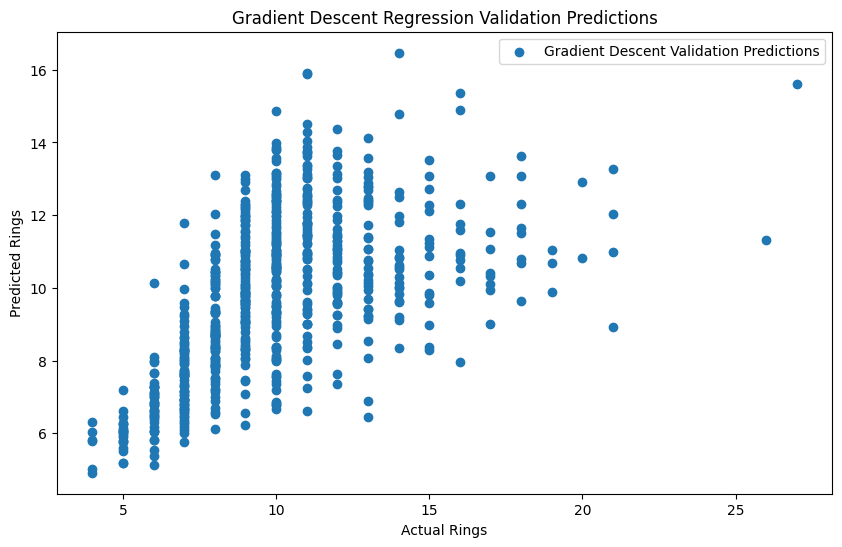

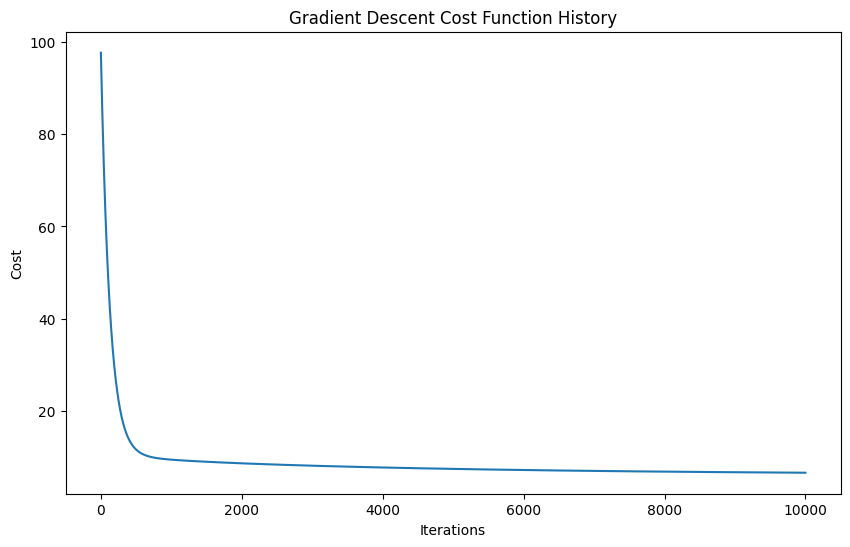

In [ ]:
### 5. Gradient Descent
# Define the cost function (Mean Squared Error)
def cost_function(params, X, y):
    return np.mean((X @ params - y) ** 2)

# Gradient Descent algorithm
def gradient_descent(X, y, learning_rate=0.001, n_iterations=10000):
    m = X.shape[0]
    n_features = X.shape[1]
    params = np.random.randn(n_features)
    cost_history = []

    for i in range(n_iterations):
        y_pred = X @ params
        gradients = (2 / m) * X.T @ (y_pred - y)
        params -= learning_rate * gradients

        # Compute cost and store it
        cost = cost_function(params, X, y)
        cost_history.append(cost)

        # Early stopping if change is negligible
        if i > 0 and abs(cost_history[-1] - cost_history[-2]) < 1e-6:
            break

    return params, cost_history

# Run Gradient Descent on the training set
gd_params, gd_cost_history = gradient_descent(X_train, y_train, learning_rate=0.001)

# Validate the model on the validation set using Gradient Descent
y_pred_val_gd = X_val @ gd_params

# Visualize Gradient Descent validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_gd, label='Gradient Descent Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Gradient Descent Regression Validation Predictions')
plt.legend()
plt.show()

# Plot cost function history for Gradient Descent
plt.figure(figsize=(10, 6))
plt.plot(gd_cost_history)
plt.title('Gradient Descent Cost Function History')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Run the below segment when youa re done reviewing individualresults to compare the performance across all the methods discussed previously.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing, least_squares
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the abalone dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
column_names = [
    'Sex', 'Length', 'Diameter', 'Height', 'WholeWeight',
    'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'
]
df = pd.read_csv(url, header=None, names=column_names)

# One-hot encode the 'Sex' column without dropping any category
df = pd.get_dummies(df, columns=['Sex'], drop_first=False)

# Define the feature matrix X and the target variable y (predicting 'Rings' as age)
X = df.drop(columns='Rings').values
y = df['Rings'].values

# Split the data into training+validation and testing sets (80% training+validation, 20% testing)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split the training+validation set into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
plt.scatter(df['Length'], df['Rings'], alpha=0.5, label='Length vs Rings')
plt.scatter(df['WholeWeight'], df['Rings'], alpha=0.5, label='WholeWeight vs Rings')
plt.xlabel('Features')
plt.ylabel('Rings (Age)')
plt.title('Abalone Dataset Feature Exploration')
plt.legend()
plt.show()

### 1. Maximum Likelihood Estimation (MLE)
# Define the likelihood function
def neg_log_likelihood(params, X, y):
    beta = params[:-1]  # coefficients
    sigma = params[-1]  # error term (standard deviation)
    y_pred = X @ beta
    residuals = y - y_pred
    nll = 0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return nll

# Initial guesses for MLE
initial_params = np.append(np.ones(X_train.shape[1]), 1)

# Fit the model using MLE on the training set
result_mle = minimize(neg_log_likelihood, initial_params, args=(X_train, y_train))
mle_params = result_mle.x

# Validate the model on the validation set using MLE
y_pred_val_mle = X_val @ mle_params[:-1]

# Visualize MLE validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_mle, label='MLE Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('MLE Regression Validation Predictions')
plt.legend()
plt.show()

### 2. Restricted Maximum Likelihood (REML)
# Define the likelihood for a mixed-effects model (simplified)
def reml_likelihood(params, X, y):
    beta = params[:-2]  # fixed effects
    sigma_e = params[-2]  # residual error
    sigma_u = params[-1]  # random effect variance
    y_pred = X @ beta
    nll = 0.5 * np.sum((y - y_pred) ** 2 / sigma_e ** 2 + np.log(sigma_e ** 2))
    reml_penalty = np.log(sigma_u ** 2)
    return nll + reml_penalty

# Fit the REML model on the training set
initial_reml = np.append(np.ones(X_train.shape[1]), [1, 1])
result_reml = minimize(reml_likelihood, initial_reml, args=(X_train, y_train))
reml_params = result_reml.x

# Validate the model on the validation set using REML
y_pred_val_reml = X_val @ reml_params[:-2]

# Visualize REML validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_reml, label='REML Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('REML Regression Validation Predictions')
plt.legend()
plt.show()

### 3. Simulated Annealing (SA)
# Define the objective function for Simulated Annealing (Residual Sum of Squares)
def objective_function(params, X, y):
    beta = params
    y_pred = X @ beta
    return np.sum((y - y_pred) ** 2)

# Fit model using Simulated Annealing on the training set
bounds = [(-10, 10)] * X_train.shape[1]
result_sa = dual_annealing(objective_function, bounds, args=(X_train, y_train))
sa_params = result_sa.x

# Validate the model on the validation set using SA
y_pred_val_sa = X_val @ sa_params

# Visualize Simulated Annealing validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_sa, label='SA Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Simulated Annealing Regression Validation Predictions')
plt.legend()
plt.show()

### 4. Levenberg-Marquardt Algorithm
# Define the residuals function
def residuals_lm(params, X, y):
    return X @ params - y

# Initial parameter guess for Levenberg-Marquardt
initial_lm = np.ones(X_train.shape[1])

# Fit model using Levenberg-Marquardt on the training set
result_lm = least_squares(residuals_lm, initial_lm, args=(X_train, y_train), method='lm')
lm_params = result_lm.x

# Validate the model on the validation set using LM
y_pred_val_lm = X_val @ lm_params

# Visualize Levenberg-Marquardt validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_lm, label='Levenberg-Marquardt Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Levenberg-Marquardt Regression Validation Predictions')
plt.legend()
plt.show()

### 5. Gradient Descent
# Define the cost function (Mean Squared Error)
def cost_function(params, X, y):
    return np.mean((X @ params - y) ** 2)

# Gradient Descent algorithm
def gradient_descent(X, y, learning_rate=0.001, n_iterations=10000):
    m = X.shape[0]
    n_features = X.shape[1]
    params = np.random.randn(n_features)
    cost_history = []

    for i in range(n_iterations):
        y_pred = X @ params
        gradients = (2 / m) * X.T @ (y_pred - y)
        params -= learning_rate * gradients

        # Compute cost and store it
        cost = cost_function(params, X, y)
        cost_history.append(cost)

        # Early stopping if change is negligible
        if i > 0 and abs(cost_history[-1] - cost_history[-2]) < 1e-6:
            break

    return params, cost_history

# Run Gradient Descent on the training set
gd_params, gd_cost_history = gradient_descent(X_train, y_train, learning_rate=0.001)

# Validate the model on the validation set using Gradient Descent
y_pred_val_gd = X_val @ gd_params

# Visualize Gradient Descent validation results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_gd, label='Gradient Descent Validation Predictions')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Gradient Descent Regression Validation Predictions')
plt.legend()
plt.show()

# Plot cost function history for Gradient Descent
plt.figure(figsize=(10, 6))
plt.plot(gd_cost_history)
plt.title('Gradient Descent Cost Function History')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Final Evaluation on Test Set
# Evaluate models on the test set
y_pred_test_mle = X_test @ mle_params[:-1]
y_pred_test_reml = X_test @ reml_params[:-2]
y_pred_test_sa = X_test @ sa_params
y_pred_test_lm = X_test @ lm_params
y_pred_test_gd = X_test @ gd_params

# Comparing Techniques on Test Set
methods = [
    'MLE', 'REML', 'Simulated Annealing',
    'Levenberg-Marquardt', 'Gradient Descent'
]
y_preds_test = [
    y_pred_test_mle, y_pred_test_reml, y_pred_test_sa,
    y_pred_test_lm, y_pred_test_gd
]

for method, y_pred in zip(methods, y_preds_test):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{method} - MSE: {mse:.3f}, R-squared: {r2:.3f}")